In [1]:
from BCI2000Tools.FileReader import bcistream
from BCI2000Tools.Numerics import events
from BCI2000Tools.Container import Bunch
import numpy; from numpy import inf, nan
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from mlxtend.evaluate import permutation_test
fileName = '/Users/samuel/Downloads/LANTTask_GARJAS001R01.dat'
b = bcistream( fileName )

## Jeremy's old code to decipher data from BCI2000

In [2]:
import numpy; from numpy import inf, nan
fileName = '/Users/samuel/Downloads/LANTTask_GARJAS001R01.dat'
b = bcistream( fileName )
signal, states = b.decode()  # WARNING: uses lots of memory! can supply an integer number of samples to make it only read part of the file

#b = bcistream( '~/Downloads/LANTTask_GARJAS001R01.dat');  
#signal, states = b.decode( 1954300 //  )

trials = Bunch()._set( _display_sorted=1 )
for eventName in 'DigitalInput3 CueVisible TargetVisible KeyDown ReactionTime'.split():
	for sampleIndex in events( states[ eventName ] ):
		blockNumber = states.BlockNum.flat[ sampleIndex ]
		trialNumber = states.TrialNumber.flat[ sampleIndex ]
		key = ( blockNumber, trialNumber )
		if key in trials: trial = trials[ key ]
		else: trial = trials[ key ] = Bunch()._set( _display_sorted=1 )
		for stateName in 'BlockNum TrialNumber CueLocation TargetLocation TargetDirection FlankerDirection KeyDown ReactionTime'.split():
			if ( stateName + 'Events' ) not in trial:
				trial[ stateName ] = states[ stateName ].flat[ sampleIndex ]		
		trial.setdefault( eventName + 'Events', [] ).append( sampleIndex / b.samplingfreq_hz )
		if eventName == 'DigitalInput3': trial[ 'TimeZeroSampleIndex' ] = sampleIndex
		trial[ 'WARNINGS' ] = []
for i, ( key, trial ) in enumerate( sorted( trials.items() ) ): trial[ 'GlobalTrialNumber' ] = i
trials = trials.__class__( sorted( trials.items() ) )

for key, trial in trials.items():
	nFlashes = trial[ 'NumberOfFlashes' ] = len( trial.setdefault( 'DigitalInput3Events', [] ) )
	nResponses = trial[ 'NumberOfKeyPresses' ] = len( trial.setdefault( 'KeyDownEvents', [] ) )
	expectedNumberOfFlashes = 1 if trial[ 'CueLocation' ] == 4 else 2
	if nFlashes != expectedNumberOfFlashes: trial[ 'WARNINGS' ].append( 'Expected %d flashes, got %d' % ( expectedNumberOfFlashes, nFlashes ) )
	if nResponses != 1: trial[ 'WARNINGS' ].append( 'Expected 1 response, got %d' % ( nResponses ) )
	
	validKeys = [ 38, 40 ] if b.params.EnableRotate90 else [ 37, 39 ]
	trial[ 'ResponseDirection' ] = 0
	if nResponses == 1: 
		if trial[ 'KeyDown' ] in validKeys:
			trial[ 'ResponseDirection' ] = 1 + validKeys.index( trial[ 'KeyDown' ] )
		else:
			trial[ 'WARNINGS' ].append( 'Expected a key in %r, got %d' % ( validKeys, trial[ 'KeyDown' ] ) )
	trial[ 'ResponseCorrect' ] = ( trial[ 'ResponseDirection' ] == trial[ 'TargetDirection' ] )
	# Direction:   1 means left or up,   2 means right or down
	
	trial[ 'CueLatencyMsec'           ] = 1000.0 * ( trial[ 'DigitalInput3Events' ][  0 ] - trial[ 'CueVisibleEvents'    ][  0 ] ) if nFlashes >= 2 else nan
	trial[ 'TargetLatencyMsec'        ] = 1000.0 * ( trial[ 'DigitalInput3Events' ][ -1 ] - trial[ 'TargetVisibleEvents' ][  0 ] ) if nFlashes >= 1 else nan
	trial[ 'ImpreciseResponseLatency' ] = 1000.0 * ( trial[ 'KeyDownEvents'       ][  0 ] - trial[ 'DigitalInput3Events' ][ -1 ] ) if nFlashes >= 1 else nan
	#trial[ 'ReactionTimeCrosscheck'   ] = 1000.0 * ( trial[ 'KeyDownEvents'       ][  0 ] - trial[ 'TargetVisibleEvents' ][ -1 ] ) if nFlashes >= 1 else nan
	
	# It's called 'imprecise' to remind us that it's measured relative to a jittered USB event
	# ReactionTime measures that jittered USB event in microseconds relative to the change in the TargetVisible state, which is itself also jittered
	# ImpreciseResponseLatency measures that jittered USB event in milliseconds relative to the light sensor signal DigitalInput3Events[ -1 ]
	# What we really need is to connect the TTL outputs of the ResponseTimeBox to DigitalInput1 and/or DigitalInput2, and compute the latency based on these relative to DigitalInput3Events[ -1 ]
	
	trial[ 'FlankersAreCongruent' ] = ( trial[ 'FlankerDirection' ] == trial[ 'TargetDirection' ] )
	trial[ 'FlankersAreIncongruent' ] = ( trial[ 'FlankerDirection' ] != trial[ 'TargetDirection' ] )
	trials[ key ] = trial.__class__( sorted( trial.items() ) )

def Get( trials, field, condition=None ):
	if condition is None: condition = lambda trial: trial[ field ] is not nan
	if isinstance( condition, str ): conditionField = condition; condition = lambda trial: trial[ conditionField ] is not nan
	return numpy.array( [ trial[ field ] for key, trial in sorted( trials.items() ) if condition( trial ) ] )


## Defining 2 functions
The first function is for the calculation of the score (alerting, orienting or executive), the second function does a 'homemade' permutation test.

In [3]:
def statistic(x, y, axis):
    return numpy.nanmean(x, axis=axis) - numpy.nanmean(y, axis=axis)

def run_permutation_test(pooled,sizeX,sizeY):
    numpy.random.shuffle(pooled)
    starX = pooled[:sizeX]
    starY = pooled[-sizeY:]
    return numpy.nanmean(starX) - numpy.nanmean(starY)

## Generate boolean variables to select data
This generates conditions in order to select data properly by performing logical operation on reaction time indices
e.g to get the reaction time for congruent flankers I will need reaction time values when the response is correct AND the flankers congruent AND block number >0 AND Trial number > 0 

this will be:
```Python
RT[Correct&Congruent&Block&TrialsNum]
```

In [4]:
Block = Get( trials,'BlockNum') > 0 #Block number has to be > 0 (0 being the test block with the 24 trials) 
TrialsNum = Get( trials,'TrialNumber') > 0 #Trial number has to be > 0 (0 being the 24 test trials) 
RT = Get( trials,'ImpreciseResponseLatency','BlockNum') #Response time
Congruent = Get( trials,'FlankersAreCongruent') #True for trials when flankers are congruents
Incongruent = Get( trials,'FlankersAreIncongruent') #True for trials when flankers are incongruents
Correct = Get( trials,'ResponseCorrect') #True for trials when response is correct
Spatial = (Get( trials,'CueLocation') == 1) | (Get( trials,'CueLocation') == 2) #True for trials when there is a spatial cue
Center  = Get( trials,'CueLocation') == 3 #True for trials when the cue is at the center
No_cue = Get( trials,'CueLocation') == 4 #True for trials when there are no cues


## Permutation test for the executive score
Test if the difference reaction time is significant between congruent and incongruent

p value from mlxtend = 0.000100 
 p value from my permutation test = 0.000100


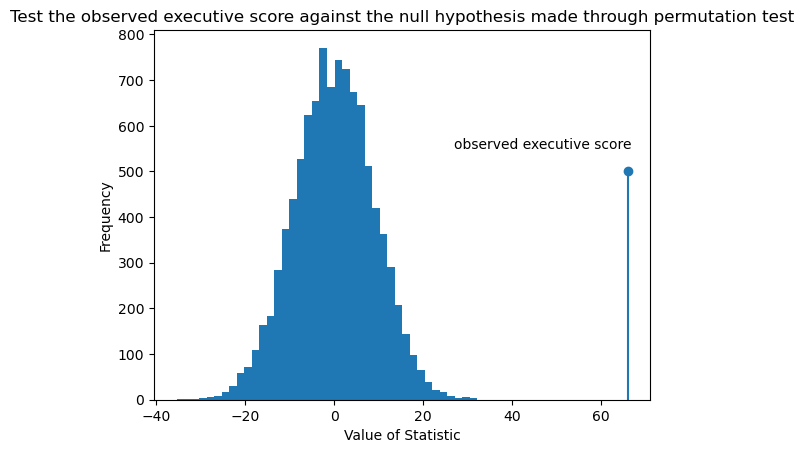

In [5]:
# For No Cue
X = RT[Correct&Incongruent&Block&TrialsNum]
Y = RT[Correct&Congruent&Block&TrialsNum]
delta = statistic(X,Y,0)
pooled = numpy.hstack([X,Y])
numSamples = 10000
estimates = []
for i in range(numSamples):
    estimates.append(run_permutation_test(pooled,X.size,Y.size))
my_p_value = ( 1 + sum( estimate >= delta for estimate in estimates ) ) / ( 2.0 + len( estimates ) ) 
p_value = permutation_test(X, Y,
                           method='approximate',
                           num_rounds=10000,
                           seed=None)
print('p value from mlxtend = %f \n p value from my permutation test = %f' %(p_value,my_p_value))

fig, ax = plt.subplots()
ax.annotate('observed executive score',[delta-39, 550])
ax.hist(estimates, bins=40)
ax.stem(delta,500)
plt.title("Test the observed executive score against the null hypothesis made through permutation test")
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.show()

## Permutation test for the orienting score
Test if the difference reaction time is significant between spatial cues and centered cues

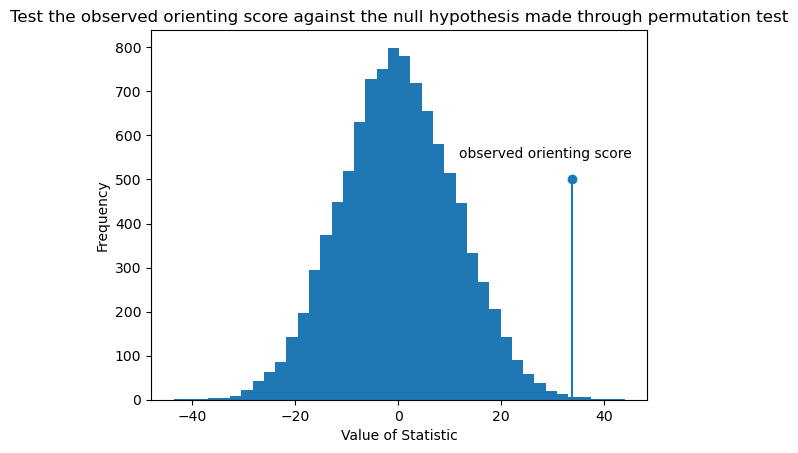

p value from mlxtend = 0.001500 
 p value from my permutation test = 0.001400


In [6]:
X = RT[Correct&Center&Block&TrialsNum]
Y = RT[Correct&Spatial&Block&TrialsNum]
delta = statistic(X,Y,0)
pooled = numpy.hstack([X,Y])
numSamples = 10000
estimates = []
for i in range(numSamples):
    estimates.append(run_permutation_test(pooled,X.size,Y.size))
    
p_value = permutation_test(X, Y,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
my_p_value = ( 1 + sum( estimate >= delta for estimate in estimates ) ) / ( 2.0 + len( estimates ) ) 

fig, ax = plt.subplots()
ax.annotate('observed orienting score',[delta-22, 550])
ax.hist(estimates, bins=40)
ax.stem(delta,500)
plt.title("Test the observed orienting score against the null hypothesis made through permutation test")
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.show()
print('p value from mlxtend = %f \n p value from my permutation test = %f' %(p_value,my_p_value))



## Permutation test for the alerting score
Test if the difference reaction time is significant between a cue and no cue

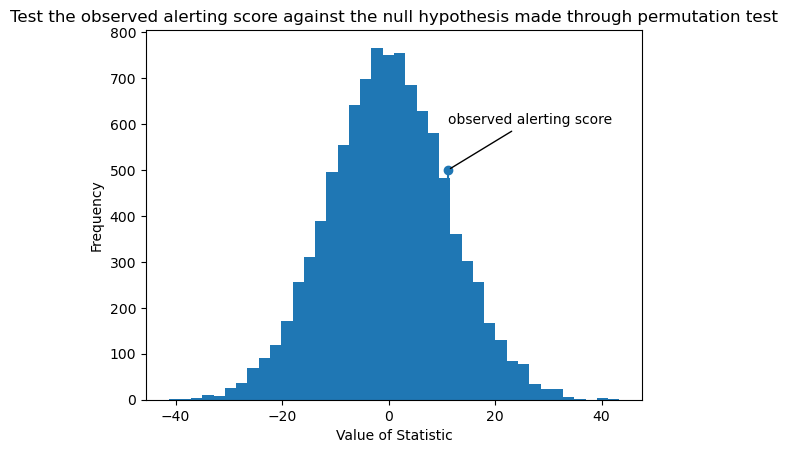

p value from mlxtend = 0.323668 
 p value from my permutation test = 0.155484


In [7]:
# For No Cue
X = RT[Correct&No_cue&Block&TrialsNum]
Y = RT[Correct&Center&Block&TrialsNum]
delta = statistic(X,Y,0)
pooled = numpy.hstack([X,Y])
numSamples = 10000
estimates = []
for i in range(numSamples):
    estimates.append(run_permutation_test(pooled,X.size,Y.size))
    
p_value = permutation_test(X, Y,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
my_p_value = ( sum( estimate >= delta for estimate in estimates ) ) / ( 1.0 + len( estimates ) ) 

fig, ax = plt.subplots()
ax.hist(estimates, bins=40)


arrowprops=dict(arrowstyle='-', color='black', linewidth=1)
an = ax.annotate('observed alerting score', xy=(delta, 500), xytext=(delta, 600), xycoords='data', 
                 textcoords='data', arrowprops=arrowprops)


ax.stem(delta,500)
plt.title("Test the observed alerting score against the null hypothesis made through permutation test")
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.show()
print('p value from mlxtend = %f \n p value from my permutation test = %f' %(p_value,my_p_value))

## Mean reaction time values between congruent and incongruent (executive network)

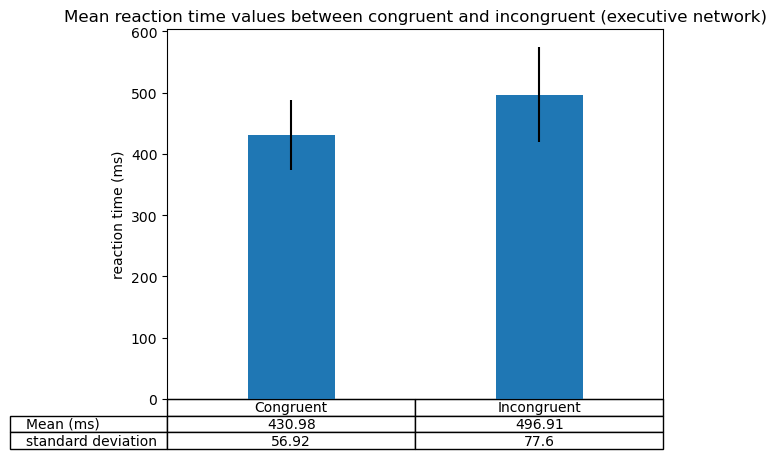

In [8]:
CongruentMean = numpy.nanmean(RT[Congruent&Correct&Block&TrialsNum])
IncongruentMean = numpy.nanmean(RT[Incongruent&Correct&Block&TrialsNum])
CongruentStd = numpy.nanstd(RT[Congruent&Correct&Block&TrialsNum])
IncongruentStd = numpy.nanstd(RT[Incongruent&Correct&Block&TrialsNum])

N = 2

# the x locations for the groups
ind = numpy.arange(N)    
# the width of the bars
width = 0.35      

plt.bar(ind,
        [CongruentMean,IncongruentMean],
        
        width,
        yerr=[CongruentStd,IncongruentStd],align='center')

plt.table(cellText=([round(CongruentMean,2),round(IncongruentMean,2)],
                    [round(CongruentStd,2),round(IncongruentStd,2)]),
          cellLoc='center',
          rowLabels=('Mean (ms)','standard deviation'),
          colLabels=('Congruent','Incongruent'),
          loc='bottom')
plt.xticks([])
plt.xlim([-0.5,+1.5])
plt.ylabel('reaction time (ms)')
plt.title("Mean reaction time values between congruent and incongruent (executive network)")

plt.show()

## Mean reaction time values between spatial and centered cues (orienting network)

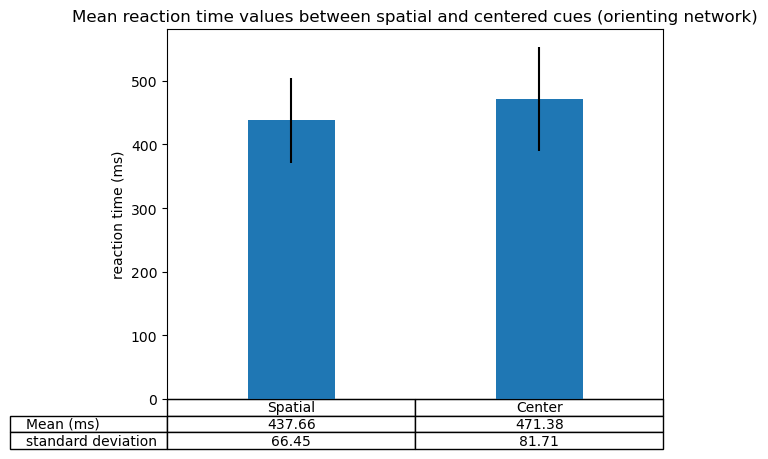

In [9]:
SpatialMean = numpy.nanmean(RT[Correct&Spatial&Block&TrialsNum])
CenterMean = numpy.nanmean(RT[Correct&Center&Block&TrialsNum])
SpatialStd = numpy.nanstd(RT[Correct&Spatial&Block&TrialsNum])
CenterStd = numpy.nanstd(RT[Correct&Center&Block&TrialsNum])

N = 2

# the x locations for the groups
ind = numpy.arange(N)    
# the width of the bars
width = 0.35      

plt.bar(ind,
        [SpatialMean,CenterMean],
        
        width,
        yerr=[SpatialStd,CenterStd],align='center')

plt.table(cellText=([round(SpatialMean,2),round(CenterMean,2)],
                    [round(SpatialStd,2),round(CenterStd,2)]),
          cellLoc='center',
          rowLabels=('Mean (ms)','standard deviation'),
          colLabels=('Spatial','Center'),
          loc='bottom')
plt.xticks([])
plt.xlim([-0.5,+1.5])
plt.ylabel('reaction time (ms)')
plt.title("Mean reaction time values between spatial and centered cues (orienting network)")

plt.show()

## Mean reaction time values between centered cues and no cues (alerting network)

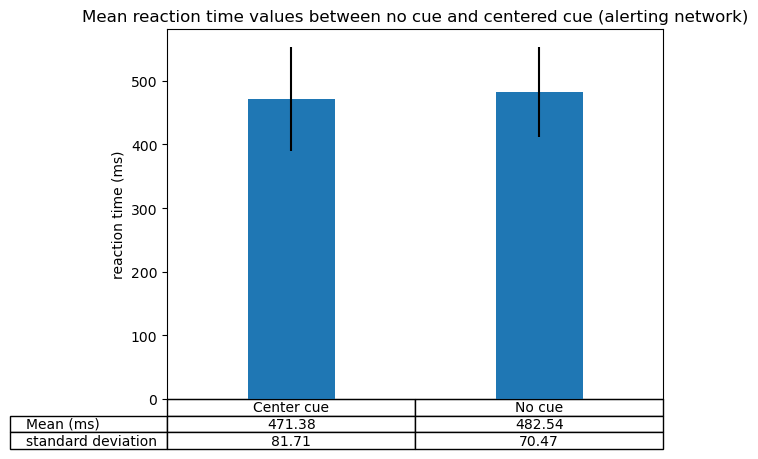

In [10]:
CenterMean = numpy.nanmean(RT[Correct&Center&Block&TrialsNum])
NoCueMean = numpy.nanmean(RT[Correct&No_cue&Block&TrialsNum])
CenterStd = numpy.nanstd(RT[Correct&Center&Block&TrialsNum])
NoCueStd = numpy.nanstd(RT[Correct&No_cue&Block&TrialsNum])

N = 2

# the x locations for the groups
ind = numpy.arange(N)    
# the width of the bars
width = 0.35      

plt.bar(ind,
        [CenterMean,NoCueMean],
        
        width,
        yerr=[CenterStd,NoCueStd],align='center')

plt.table(cellText=([round(CenterMean,2),round(NoCueMean,2)],
                    [round(CenterStd,2),round(NoCueStd,2)]),
          cellLoc='center',
          rowLabels=('Mean (ms)','standard deviation'),
          colLabels=('Center cue','No cue'),
          loc='bottom')
plt.xticks([])
plt.xlim([-0.5,+1.5])
plt.ylabel('reaction time (ms)')
plt.title("Mean reaction time values between no cue and centered cue (alerting network)")

plt.show()

## Alerting, orienting and executive score values and accuracy

In [11]:

AlertingScore = numpy.nanmean(RT[Correct&No_cue&Block&TrialsNum]) - numpy.nanmean(RT[Correct&Center&Block&TrialsNum])
OrientingScore = numpy.nanmean(RT[Correct&Center&Block&TrialsNum]) - numpy.nanmean(RT[Correct&Spatial&Block&TrialsNum])
ExecutiveScore = numpy.nanmean(RT[Correct&Incongruent&Block&TrialsNum]) - numpy.nanmean(RT[Correct&Congruent&Block&TrialsNum])
Accuracy = numpy.count_nonzero([Correct&Block&TrialsNum])*100/numpy.count_nonzero([Block&TrialsNum])
print("Alerting score = %f \n Orienting score = %f \n Executive score = %f \n Accuracy = %d%%" %(AlertingScore,OrientingScore,ExecutiveScore,Accuracy))

Alerting score = 11.160498 
 Orienting score = 33.720094 
 Executive score = 65.928780 
 Accuracy = 98%
